# Coco Manager Usage Example


In [1]:

import torch
import torchvision as tv
import torch.nn as nn

import numpy as np
from pycocotools.coco import COCO
from PIL import Image

import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

import itertools
import os
from typing import Dict, Tuple, List

from skimage.morphology import disk, closing
from skimage import io


## Coco_Manager class import from GitHub

In [2]:
%%bash
rm -rf Coco_Manager || true
git clone https://github.com/McCastles/Coco_Manager

In [3]:
%run Coco_Manager/Coco_Manager.ipynb import Coco_Manager

## Usage Example

In [5]:

root = '../data/COCO/'

# This path is needed if the images are downloaded on the disk
# Ignore if only annotations JSON files are on the disk
path_traindata = root + 'train2017/'
path_valdata   = root + 'val2017/'

# This path is needed anyway to create a coco object
# It contains masks, bboxes and download URLs
path_trainjson = root + 'annotations/instances_train2017.json'
path_valjson   = root + 'annotations/instances_val2017.json'


In [6]:
# # Colab Stuff
# from google.colab import drive
# drive.mount('/content/drive')
# root = "/content/drive/MyDrive/"
# path_trainjson = root + "Projects/FCN/annotations_trainval2017/annotations/instances_train2017.json"
# path_valjson   = root + "Projects/FCN/annotations_trainval2017/annotations/instances_val2017.json"

Mounted at /content/drive


In [7]:

# Desired images size (scaling; cropping coming soon)
output_size = (384, 384)


In [8]:

# Using both local images and annotations:
# coco = COCO( path_trainjson )
# cm = Coco_Manager( coco=coco, local_imgs_path=path_traindata )

# Another way
# (coco object is created inside, in Jupyter it's better to create coco beforehand):
#
# cm = Coco_Manager( path_ann=path_trainjson,
#                              local_imgs_path=path_traindata,
#                              output_size=output_size )

# Using only annotations:
# cm = Coco_Manager( path_ann=path_trainjson, output_size=output_size )
# or

coco = COCO( path_trainjson )


loading annotations into memory...
Done (t=26.31s)
creating index...
index created!


In [9]:

# Coco Manager instance
cm = Coco_Manager( coco=coco, output_size=output_size )


(Full Set) Images found: 118287


In [11]:

# Making a subset of the dataset

# Searches for all the images with both classes present simultaneously
cm.make_subset( classes=['person', 'cat'], intersection=True )

# Images with the first class or the second (or both)
# cm.make_subset( classes=['person', 'cat'], intersection=False )


(Subset) Images found: 693/118287 (0.59%)


In [12]:

# Pytorch DataLoader creation
batch_size = 4

loader_test = torch.utils.data.DataLoader(
    cm,
    batch_size=batch_size,
    shuffle=True,
    collate_fn=cm.collate_fn )

dataiter = iter(loader_test)


In [13]:

# Random Batch
batch = dataiter.next()
batch['imgs'].size()


torch.Size([4, 384, 384, 3])

In [15]:

# 'boxes':                    Tensors [xmin, ymin, xmax, ymax, width, height]
# 'masks':                    Tensors of shape [ batch_size, num_classes, img_width, img_height ]
# 'labels':                   Strings, Coco classes for each object
# 'coco_id':                  Image Coco ID
# 'areas':                    Areas of the bounding boxes

batch['anns'][0].keys()


dict_keys(['boxes', 'masks', 'labels', 'coco_id', 'areas'])

In [17]:

# Mask of the first image
mask = batch['anns'][0]['masks']
print( mask.size() )
print( np.unique(mask) )


torch.Size([384, 384, 2])
[0. 1.]


IMAGE SIZE = torch.Size([384, 384, 3])


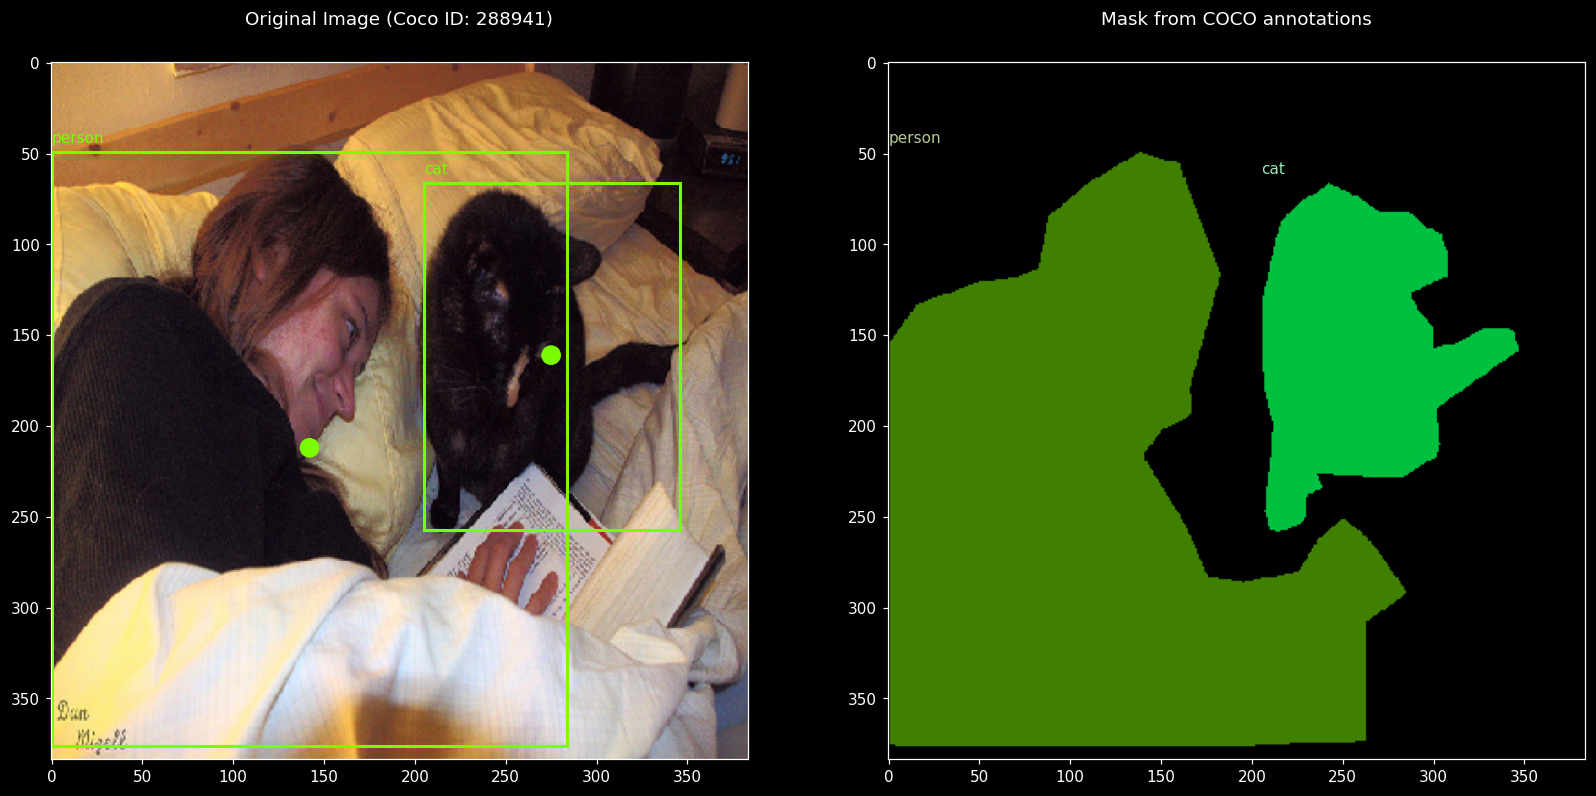

In [19]:

# Display

for img_id in range(batch_size):
    img = batch['imgs'][img_id]
    anns = batch['anns'][img_id]
    cm.show(img, anns)

    print( f'IMAGE SIZE = {img.size()}')
    break
